In [1]:
from scipy.sparse import identity
import networkx as nx
import numpy as np
import pandas as pd

def get_polarization(g):

    """"
    Creates the L+I matrix where L is the laplacian matrix of
    the graph. Solves the (L+I)^-1 * S system and computes t-
    he polarization index value from the second norm of this
    array squared up and normalized by the network size.

    ----------------------------------------------------------
    :param g: networkx graph with value attributes
    :return: Value of the polarization index
    """
    no_of_nodes = len(g.nodes)
    values = list(nx.get_node_attributes(g, 'value').values())

    Laplace = nx.laplacian_matrix(g)
    Identity = identity(no_of_nodes)
    L_plus_I = Laplace + Identity

    # sum of columns of L+I should be 1 for each column
    #print(pd.DataFrame(L_plus_I.todense()).sum(axis=1, skipna=True))

    Inverse = np.linalg.inv(L_plus_I.todense())

    # sum of columns of (L+I)^-1 should be 1 for each column
    #print(pd.DataFrame(Inverse.A).sum(axis=1, skipna=True))

    # computing (L+I)^-1 * S
    solutions = Inverse.dot(values)

    #print(pd.DataFrame(Inverse.A))
    #print(values)

    #print(sum(np.squeeze(np.asarray(solutions)).tolist()))

    # squaring and summing the opinion vector
    squared = np.square(solutions)

    summed = np.sum(squared)
    # result is normalized according to network size
    return summed / no_of_nodes, np.squeeze(np.asarray(solutions)).tolist()

In [2]:
graph = nx.read_gml('../datasets/books.gml', label='id')

graph = nx.Graph(graph, name='books')

# GREEDY

In [3]:
g_copy = graph.copy()
k_items = []
k = [5,10,15,20]

for i in range(max(k)):
    
    
    original_polarization, converged_opinions = get_polarization(g_copy)
    
    index_pos = []
    index_neg = []
    edges_to_add_list = []
    addition_info = {}

    # separate them according to opinion (-,+)
    # dont use list.index(), some nodes have the exact z value
    # and will return the same index in the list providing us
    # with wrong edges to add bellow

    for i in range(len(converged_opinions)):
        if converged_opinions[i] > 0:
            index_pos.append(i)
        elif converged_opinions[i] < 0:
            index_neg.append(i)


    for node_pos in index_pos:
        for node_neg in index_neg:
            
            edge_to_add = (node_pos, node_neg)

            # check how much the polarization was reduced in comparison with the original graph
            g_test = g_copy.copy()
            g_test.add_edges_from([edge_to_add])
            polarization_after_addition, converged_opinions = get_polarization(g_test)


            if polarization_after_addition < original_polarization:
                value = original_polarization - polarization_after_addition
            else:
                # polarization increased
                value = 999999

            addition_info[edge_to_add] = value

    sorted_edges = sorted(addition_info.items(), key=lambda x: x[1], reverse=True)
    

    # consider only edges that do not already exist
    for edge in sorted_edges:
        if not g_copy.has_edge(*edge[0]):
            edges_to_add_list.append(edge[0])

    edge_1 = edges_to_add_list[0][0]
    edge_2 = edges_to_add_list[0][1]

    g_copy.add_edge(edge_1, edge_2)
    k_items.append((edge_1, edge_2))
    

In [4]:
polarizations = []

for k_edge in k:
    
    g_test_2 = graph.copy()
    g_test_2.add_edges_from(k_items[:k_edge])
    pol, converged_opinions = get_polarization(g_test_2)
    polarizations.append(pol)


In [5]:
greedy_pol_all = []

for i in range(max(k)):
    
    g_test_2 = graph.copy()
    g_test_2.add_edges_from(k_items[:i+1])
    pol, converged_opinions = get_polarization(g_test_2)
    greedy_pol_all.append(pol)
    

## polarizations for edges 5,10,15

In [6]:
print(polarizations)

[0.3203808165510762, 0.24737040884194433, 0.1974822943940203, 0.15947351056774497]


# expressed distance

In [7]:
g_copy_expressed = graph.copy()
k_items_expressed = []
k = [5,10,15,20]

for i in range(max(k)):
    
    
    original_polarization, converged_opinions = get_polarization(g_copy_expressed)
    
    index_pos = []
    index_neg = []
    edges_to_add_list = []
    addition_info = {}

    # separate them according to opinion (-,+)
    # dont use list.index(), some nodes have the exact z value
    # and will return the same index in the list providing us
    # with wrong edges to add bellow

    for i in range(len(converged_opinions)):
        if converged_opinions[i] > 0:
            index_pos.append(i)
        elif converged_opinions[i] < 0:
            index_neg.append(i)


    for node_pos in index_pos:
        for node_neg in index_neg:
            
            edge_to_add = (node_pos, node_neg)
                                
            value = abs(converged_opinions[node_pos] - converged_opinions[node_neg])
            
            addition_info[edge_to_add] = value

    sorted_edges = sorted(addition_info.items(), key=lambda x: x[1], reverse=True)
    

    # consider only edges that do not already exist
    for edge in sorted_edges:
        if not g_copy_expressed.has_edge(*edge[0]):
            edges_to_add_list.append(edge[0])

    edge_1 = edges_to_add_list[0][0]
    edge_2 = edges_to_add_list[0][1]

    g_copy_expressed.add_edge(edge_1, edge_2)
    k_items_expressed.append((edge_1, edge_2))
    

In [8]:
polarizations_expressed = []

for k_edge in k:
    
    g_test_2 = graph.copy()
    g_test_2.add_edges_from(k_items_expressed[:k_edge])
    pol, converged_opinions = get_polarization(g_test_2)
    polarizations_expressed.append(pol)

## polarizations for edges 5,10,15

In [9]:
print(polarizations_expressed)

[0.32317278859480814, 0.25017323433937527, 0.19663534922975412, 0.15745178751223105]


In [10]:
expressed_pol_all = []

for i in range(max(k)):
    
    g_test_2 = graph.copy()
    g_test_2.add_edges_from(k_items_expressed[:i+1])
    pol, converged_opinions = get_polarization(g_test_2)
    expressed_pol_all.append(pol)
    

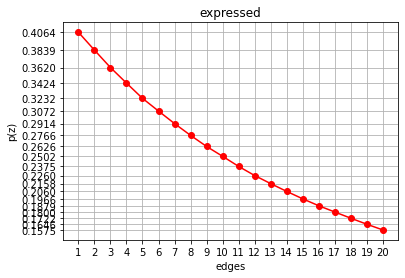

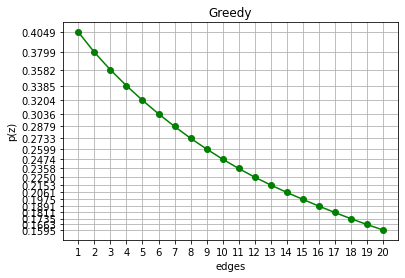

In [12]:
import matplotlib.pyplot as plt
k_all = [i+1 for i in range(20)]
plt.plot(k_all,expressed_pol_all,color='red', marker='o')

plt.xlabel('edges')
plt.ylabel('p(z)')
plt.title('expressed')
plt.xticks(k_all)
plt.yticks(expressed_pol_all)
plt.grid(True)
plt.show()

plt.plot(k_all,greedy_pol_all,color='green', marker='o')

plt.xlabel('edges')
plt.ylabel('p(z)')
plt.title('Greedy')
plt.xticks(k_all)
plt.yticks(greedy_pol_all)
plt.grid(True)
plt.show()

In [14]:
for i in range(len(k_all)):
    if greedy_pol_all[i] < expressed_pol_all[i]:
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12


In [17]:
print(k_items)
rlist(set(k_items+k_items_expressed))
print(len(res))

[(35, 59), (33, 100), (40, 84), (10, 94), (13, 99), (23, 97), (34, 98), (15, 61), (41, 89), (43, 60), (11, 92), (47, 90), (8, 87), (17, 81), (39, 95), (16, 88), (56, 63), (54, 80), (26, 79), (44, 101)]
20
40


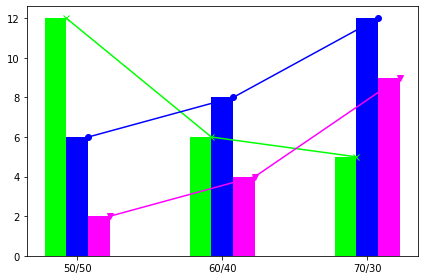

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# fig, is the whole thing; ax1 is a subplot in the figure, 
# so we reference it to plot bars and lines there
fig, ax1 = plt.subplots()

ind = np.arange(3)
width = 0.15

# per dimension
colors = ['#00ff00', '#0000ff', '#ff00ff']
markers = ['x','o','v']
xticklabels = ['50/50', '60/40', '70/30']

# 
group1 = [12,6,5]
group2 = [6,8,12]
group3 = [2,4,9]

#
all_groups = [ group1, group2, group3 ]

# plot each group of bars; loop-variable bar_values contains values for bars
for i, bar_values in enumerate( all_groups ):

  # compute position for each bar
  bar_position = width*i
  ax1.bar( ind + bar_position, bar_values, width, color=colors[i] )

# plot line for each group of bars; loop-variable y_values contains values for lines
for i, y_values in enumerate( all_groups ):

  # moves the beginning of a line to the middle of the bar
  additional_space = (width*i) + (width/2);
  # x_values contains list indices plus additional space
  x_values = [ x + additional_space for x,_ in enumerate( y_values ) ]

  # simply plot the values in y_values
  ax1.plot( x_values, y_values, marker=markers[i], color=colors[i] )

plt.setp([ax1], xticks=ind + width, xticklabels=xticklabels)

plt.tight_layout()
plt.show()